In [89]:
import pandas as pd
import numpy as np
import csv
from copy import deepcopy
from pandas import datetime
from copy import deepcopy
import gc
import random
import datetime
import csv
from copy import deepcopy
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm_notebook
from Downloader import Extractor
from Preprocessing import Preprocessor, set_onelevel, set_multilevel
from Filters import XGBFilter
from Filters import quantile_huber_loss, quantile_huber_obj 
import pickle
import xgboost as xgb
import seaborn as sns
sns.set()
%matplotlib inline

In [90]:
# getting file tree in directory "data_csv", which contains raw unfiltered data
mypath = './data_csv/Raw/'
dateparse = pd.to_datetime
station_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) if int(f.split('_', 1)[0])]
station_files.sort()

# reading loaded csv files from data_csv directory, output is a list (length=number of stations) of raw df 
raw_lmeteo_list = [pd.read_csv(mypath + '/' + station, index_col=0, 
                    dtype={'station_id': int,'date_time': str}, 
                    date_parser = dateparse, parse_dates = ['date_time']) 
                   for station in tqdm_notebook(station_files[:6])]

#fix problems with indexing, later this will be solved in loading part
for elem in raw_lmeteo_list:
    elem.reset_index(drop=True, inplace=True)

raw_data = pd.concat(raw_lmeteo_list)
raw_data['id'] = random.sample(range(len(raw_data)), len(raw_data))
raw_data['valid'] = True
raw_data = raw_data.reset_index(drop=True)

del raw_lmeteo_list
gc.collect()



34869

In [25]:
raw_data.iloc[39:50]

,station_data_id,sensor_id,data,station_id,sensor_type_id,active_state,name,rule_id,rule_ordr,direction,lane_traffic,date_time,poll_interval,fake_data,type,unit_of_measure,description,id,valid
39,7141310.0,6023.0,1000.0,113,4.0,A,NaN,6.0,18.0,0.0,0.0,2012-09-18 23:32:49,NaN,NaN,dampness,NaN,dampness (sw),1351989,True
40,7141542.0,6032.0,7423.0,113,16.0,A,NaN,152.0,36.0,0.0,0.0,2012-09-19 00:03:09,NaN,NaN,pressure,NaN,pressure (sw),1788080,True
41,7141542.0,6021.0,61.0,113,2.0,A,NaN,154.0,14.0,0.0,0.0,2012-09-19 00:03:09,NaN,NaN,t_road,NaN,t_road (sw),1192283,True
42,7141542.0,6020.0,71.0,113,1.0,A,NaN,4.0,12.0,0.0,0.0,2012-09-19 00:03:09,NaN,NaN,t_air,NaN,t_air (sw),1644805,True
43,7141542.0,6022.0,61.0,113,3.0,A,NaN,155.0,16.0,0.0,0.0,2012-09-19 00:03:09,NaN,NaN,t_underroad,NaN,t_underroad (sw),721737,True
44,7141542.0,6023.0,1000.0,113,4.0,A,NaN,6.0,18.0,0.0,0.0,2012-09-19 00:03:09,NaN,NaN,dampness,NaN,dampness (sw),1547331,True
45,7141796.0,6032.0,7414.0,113,16.0,A,NaN,152.0,36.0,0.0,0.0,2012-09-19 00:34:59,NaN,NaN,pressure,NaN,pressure (sw),923205,True
46,7141796.0,6021.0,56.0,113,2.0,A,NaN,154.0,14.0,0.0,0.0,2012-09-19 00:34:59,NaN,NaN,t_road,NaN,t_road (sw),359421,True
47,7141796.0,6020.0,60.0,113,1.0,A,NaN,4.0,12.0,0.0,0.0,2012-09-19 00:34:59,NaN,NaN,t_air,NaN,t_air (sw),39334,True
48,7141796.0,6022.0,58.0,113,3.0,A,NaN,155.0,16.0,0.0,0.0,2012-09-19 00:34:59,NaN,NaN,t_underroad,NaN,t_underroad (sw),1641809,True


In [91]:
%%time
preprocessor = Preprocessor()
meteo_splitted = preprocessor.PivotTable(raw_data)
# del raw_data

patterns_list = preprocessor.CreatePatternList(meteo_splitted)
# del pivoted_df

patterns_interpolated = preprocessor.InterpolatePatterns(patterns_list)
# del patterns_list

patterns_lagged = preprocessor.CreateLaggedTable(patterns_interpolated)
# del patterns_interpolated

final_all = pd.concat(patterns_lagged).reset_index(drop=True)

CPU times: user 1min 20s, sys: 684 ms, total: 1min 21s
Wall time: 1min 44s


In [107]:
final_all.shape

(337115, 117)

In [115]:
fin_mask = final_all.columns.get_level_values(1) <= 0
final = final_all[final_all.columns[fin_mask]]
col1 = final.columns

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
from sklearn.decomposition import PCA

In [95]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [128]:
final = pd.read_csv("past_and_current?dl=0", tupleize_cols=True, header=[0, 1], skipinitialspace=False, index_col=[0])
final.columns = pd.MultiIndex.from_tuples(final.columns)
col2 = final.columns

col2

MultiIndex(levels=[['data_dampness', 'data_pressure', 'data_t_air', 'data_t_road', 'data_t_underroad', 'date_time', 'id_dampness', 'id_pressure', 'id_t_air', 'id_t_road', 'id_t_underroad', 'station_id', 'valid_dampness', 'valid_pressure', 'valid_t_air', 'valid_t_road', 'valid_t_underroad'], ['-0.5', '-1.0', '-1.5', '-2.0', '-2.5', '-3.0', '-3.5', '-4.0', '-4.5', '-5.0', '-5.5', '-6.0', '0.0']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 11, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16], [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]])

In [74]:
def params_analysis(pr, title, n_pca = 2):
    plt.close('all')
    print( "Analysis for", title)
    df = final[pr]
    
    print(df.shape)
    scaler = StandardScaler().fit(df)
    X_scaled_pr = scaler.transform(df)
    
    pca_all = PCA()
    pca_all.fit(X_scaled_pr)
    pca = PCA(n_components= n_pca)
    X_pca_pr = pca.fit_transform(X_scaled_pr)
    
    f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(15,10))
        
    ax1.plot(pca_all.explained_variance_ratio_)
    ax1.set_title("PCA  explained variance ratio " + title) 

    
    ax2.scatter(X_pca_pr[:, 0], X_pca_pr[:, 1])
    ax2.set_title("PCA " + title)
        
    
    plt.show()

Analysis for Dampness
(337115, 13)


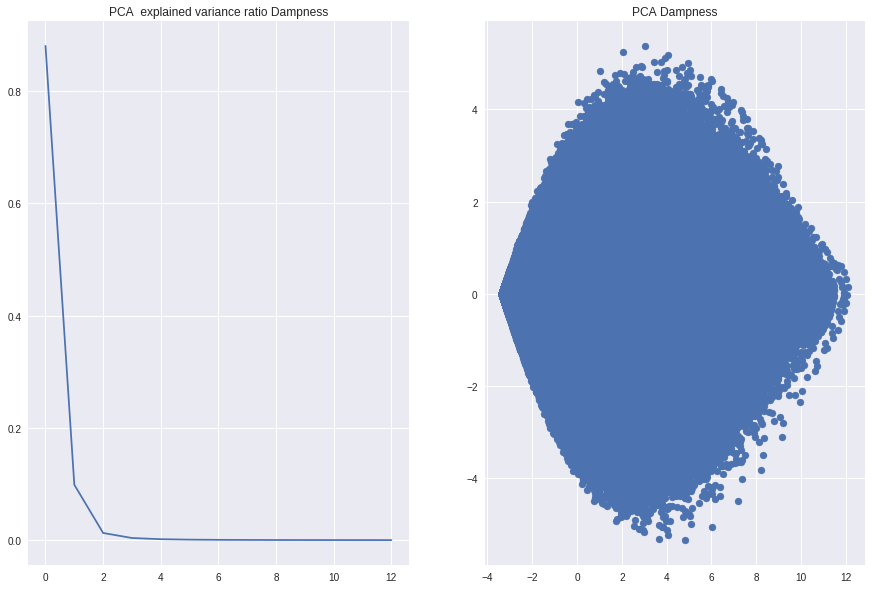

Analysis for Air temperature
(337115, 13)


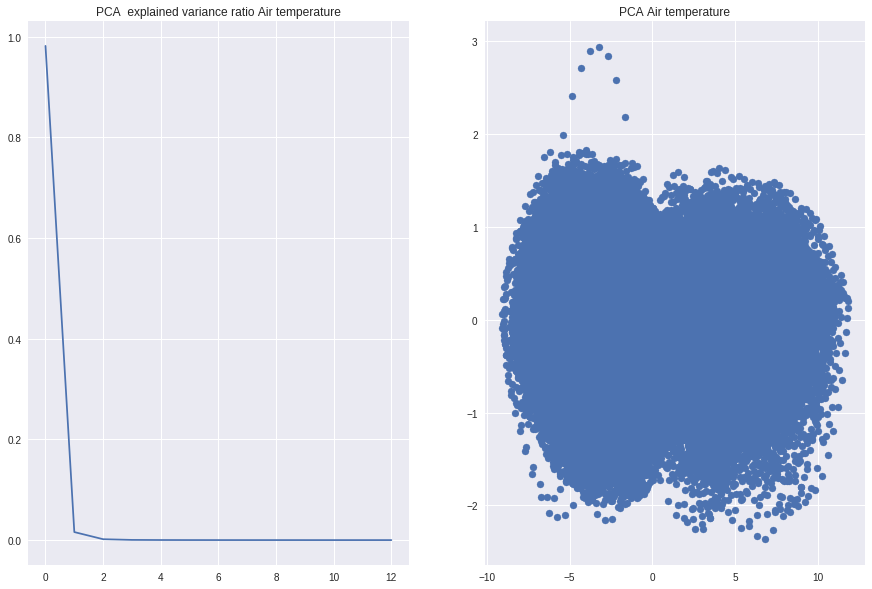

Analysis for Road temperature
(337115, 13)


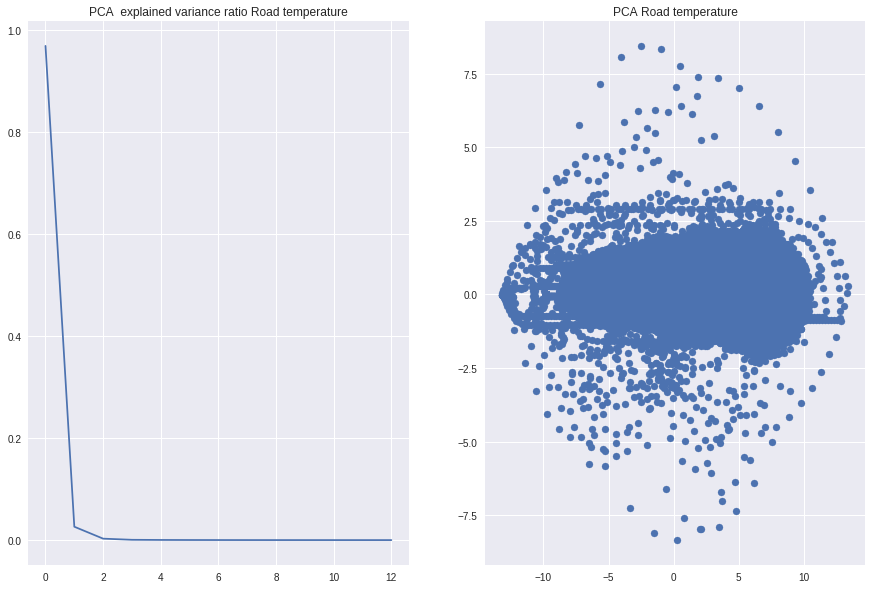

Analysis for Underroad temperature
(337115, 13)


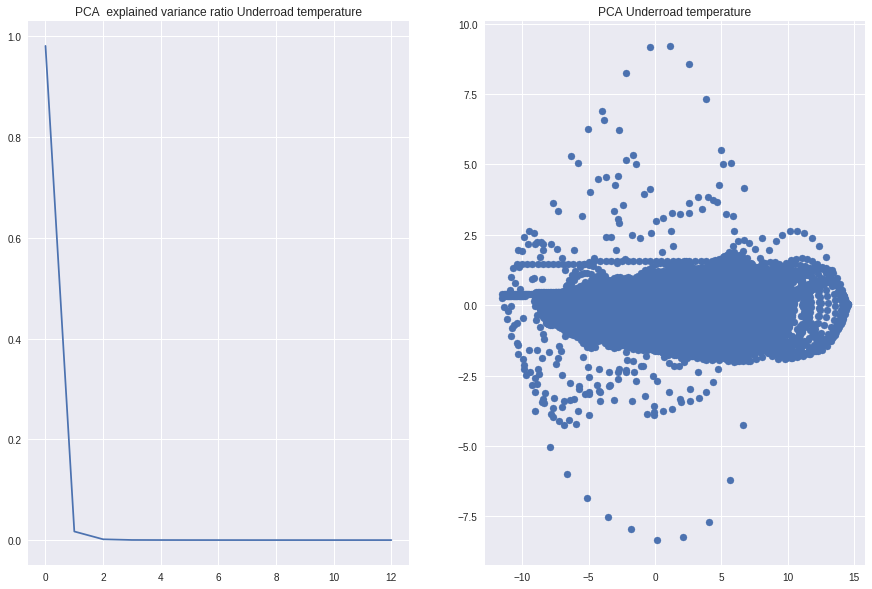

Analysis for Pressure
(337115, 13)


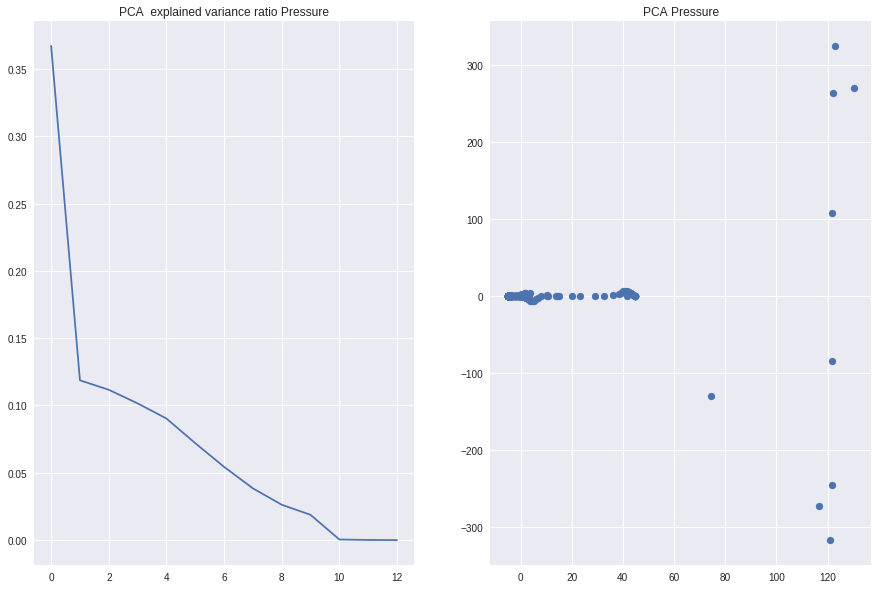

In [75]:
params_analysis('data_dampness', "Dampness")
params_analysis('data_t_air', "Air temperature")
params_analysis('data_t_road', "Road temperature")
params_analysis('data_t_underroad', "Underroad temperature")
params_analysis('data_pressure', "Pressure")

In [76]:
df = final['data_pressure']

scaler = StandardScaler().fit(df)
X_scaled_pr = scaler.transform(df)
pca_all = PCA()
pca_all.fit(X_scaled_pr)
pca = PCA(n_components= 2)
X_pca_pr = pca.fit_transform(X_scaled_pr)


itemindex = np.where(X_pca_pr[:,0] > 60)
itemindex

(array([49, 50, 51, 52, 53, 54, 55, 56, 57]),)

In [77]:
df.iloc[49]

lag
-6.0    7.463631e+03
-5.5    7.463000e+03
-5.0    7.464977e+03
-4.5    7.467540e+03
-4.0    7.470103e+03
-3.5    7.471000e+03
-3.0    7.464902e+03
-2.5    7.463000e+03
-2.0    7.463000e+03
-1.5    7.469851e+03
-1.0    7.467579e+03
-0.5    7.463798e+03
 0.0    5.600193e+06
Name: 49, dtype: float64

In [78]:
df = final['data_pressure']
df.iloc[49:58]

lag,-6.0,-5.5,-5.0,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,0.0
49,7463.631409,7463.000000,7464.976504,7467.539694,7.470103e+03,7.471000e+03,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06
50,7463.000000,7464.976504,7467.539694,7470.102884,7.471000e+03,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06
51,7464.976504,7467.539694,7470.102884,7471.000000,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03
52,7467.539694,7470.102884,7471.000000,7464.902256,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03
53,7470.102884,7471.000000,7464.902256,7463.000000,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03
54,7471.000000,7464.902256,7463.000000,7463.000000,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03
55,7464.902256,7463.000000,7463.000000,7469.851385,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03,7.470279e+03
56,7463.000000,7463.000000,7469.851385,7467.578630,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03,7.470279e+03,7.471000e+03
57,7463.000000,7469.851385,7467.578630,7463.798110,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03,7.470279e+03,7.471000e+03,7.471000e+03


(337115, 13)
(337098, 13)


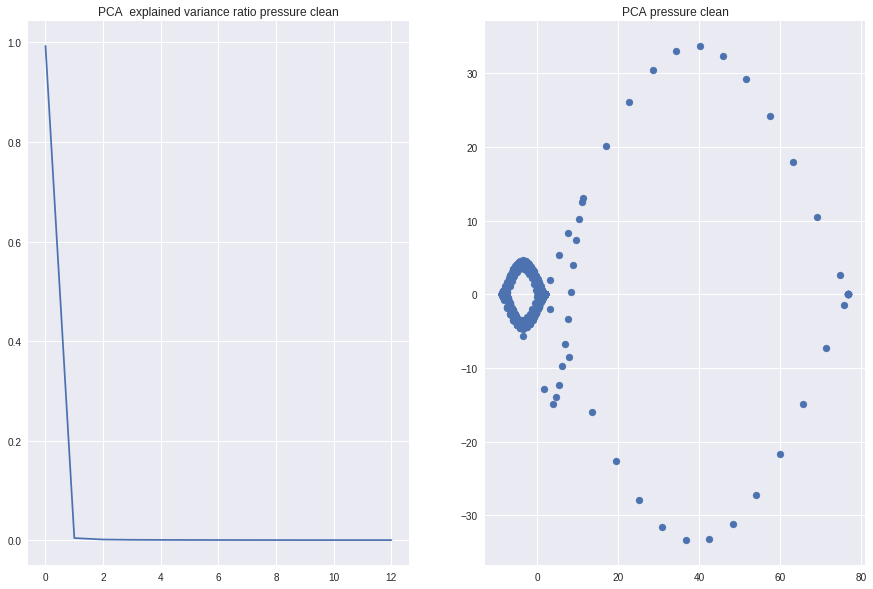

In [82]:
df = final['data_pressure']

print(df.shape)

pressure_clean = df.drop(df.index[range(42,59)])
print(pressure_clean.shape)

scaler = StandardScaler().fit(pressure_clean)
X_scaled_pr = scaler.transform(pressure_clean)
pca_all = PCA()
pca_all.fit(X_scaled_pr)
pca = PCA(n_components= 2)
X_pca_pr = pca.fit_transform(X_scaled_pr)

title = "pressure clean"

f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(15,10))
        
ax1.plot(pca_all.explained_variance_ratio_)
ax1.set_title("PCA  explained variance ratio " + title) 


ax2.scatter(X_pca_pr[:, 0], X_pca_pr[:, 1])
# ax2.set_xlim(right = 5)
ax2.set_title("PCA " + title)


plt.show()

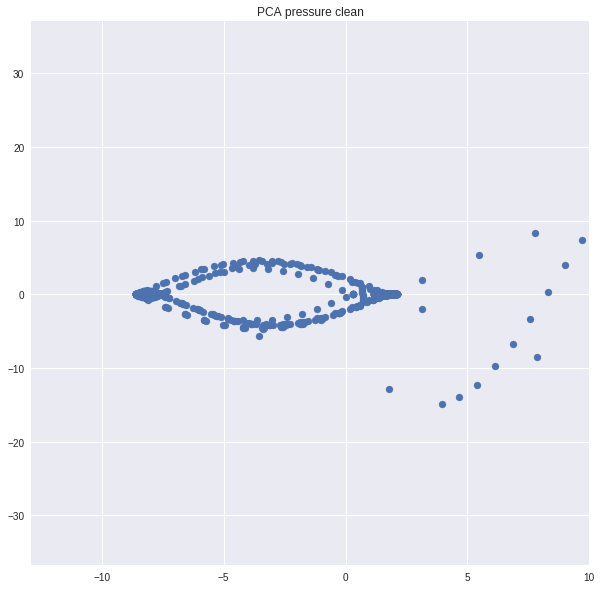

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca_pr[:, 0], X_pca_pr[:, 1])
plt.xlim(right = 10)
plt.title("PCA " + title)


plt.show()

In [84]:
itemindex = np.where(X_pca_pr[:,0] > 5)
itemindex

(array([321964, 321965, 321966, 321967, 321968, 321969, 321970, 321971,
        321972, 321973, 323358, 323359, 323360, 323361, 323362, 323363,
        323364, 323365, 323366, 323367, 323368, 323369, 323370, 323371,
        323372, 323373, 323374, 323375, 323376, 323377, 323378, 323379,
        323380, 323381, 323382, 323383, 323384, 323385, 323386, 323387,
        323388, 323389, 323390, 323391, 323392, 323393]),)

In [85]:
pressure_clean.iloc[range(321964, 321976)]

lag,-6.0,-5.5,-5.0,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,0.0
321981,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839
321982,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853
321983,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000
321984,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000
321985,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000
321986,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000
321987,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000,740.000000
321988,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
321989,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
321990,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000


In [87]:
import matplotlib.font_manager
from sklearn import svm

df = final['data_t_underroad']

print(df.shape)
scaler = StandardScaler().fit(df)
X_scaled_pr = scaler.transform(df)

pca_all = PCA()
pca_all.fit(X_scaled_pr)
pca = PCA(n_components= 2)
X_pca_pr = pca.fit_transform(X_scaled_pr)



xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

(337115, 13)


In [88]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_pca_pr)
y_pred_train = clf.predict()

TypeError: predict() missing 1 required positional argument: 'X'